In [21]:
#Importing libraries and dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

rng = np.random.RandomState(42)
import pickle
#All the features
import os
path = 'C:\Prashant\Teradata\Analytics\IOT\Waseem'
os.chdir(path)



In [22]:
import pandas as pd
oddata1 = pd.read_csv('oddata1.csv')
list(oddata1)
print(oddata1.head)

<bound method DataFrame.head of              f1        f2        f3        f4        f5        f6        f7  \
0      0.121020  0.115043  0.018801  0.009065  0.006449  0.020476  0.058333   
1      0.140722  0.218772  0.040333  0.055266  0.040063  0.028287  0.102752   
2      0.081126  0.065491  0.029324  0.004907  0.012861  0.031133  0.064110   
3      0.265287  0.066680  0.036866  0.023651  0.039152  0.076241  0.052662   
4      0.138840  0.166306  0.035365  0.019242  0.022293  0.069795  0.168669   
5      0.201089  0.125812  0.056817  0.039057  0.024759  0.036542  0.115876   
6      0.115716  0.087405  0.016548  0.042113  0.035783  0.029057  0.086460   
7      0.144406  0.126956  0.033561  0.018372  0.019512  0.043305  0.097427   
8      0.074970  0.048214  0.012097  0.021212  0.014892  0.031853  0.023747   
9      0.071482  0.054838  0.019940  0.014819  0.007688  0.062954  0.064475   
10     0.076270  0.070598  0.017014  0.018519  0.010254  0.018025  0.047357   
11     0.173213  0.1

In [23]:
oddataarr = oddata1.loc[oddata1.f1>0.002,['f1','f2','f3','f4','f5','f6','f7','f8','f9']]
oddataarr.shape

#Divide the data into training and test set
msk = np.random.rand(len(oddataarr)) < 0.8

train = oddataarr[msk]

test = oddataarr[~msk]

In [24]:
# fit the model Isolation Forest
clf = IsolationForest(max_samples=10000, random_state=rng,contamination=0.05)
clf.fit(train)
#y_pred_train = clf.predict(train)
y_pred_test_IF_all = clf.predict(test)



In [25]:
#fit the model One class svm
clf = OneClassSVM(kernel='rbf', degree=3, gamma='auto', coef0=0.0, tol=0.001, nu=0.05, random_state=rng)
clf.fit(train)
#y_pred_train = clf.predict(train)
y_pred_test_OSVM_all = clf.predict(test)

In [26]:
# model each columns seperately
namespace = globals()
   
def modelthiscol(i,thresold):
   
    namespace['trainf%s' % i] = train[[eval("'f'+str(i)")]]
    #One class svm for f1
    clf = OneClassSVM(kernel='rbf', degree=3, gamma='auto', coef0=0.0, tol=0.001, nu=thresold, random_state=rng)
    clf.fit(namespace['trainf%s' % i])
    
    namespace['y_pred_testf%s' % i] = clf.predict(test[[eval("'f'+str(i)")]])
    
    return namespace['y_pred_testf%s' % i]

for i in range(1,10):
    namespace['fcol%s' % i] = modelthiscol(i,0.05)

In [27]:
#Prediction Plot function


def plotprediction(fcol,col1,col2):
    y_pred_test = fcol
    
    #seggregating anamolies from normal for analysis
    df = pd.DataFrame(y_pred_test)
    df = df.rename(columns={0: 'pred'})
    #print(df)
    
    
    df_c = pd.concat([test.reset_index(drop=True), df], axis=1)
    
    y1 = df_c[(df['pred'] == 1)]
    yminus1 = df_c[(df['pred'] == -1)]
    
    plt.title('Scatter plot %s vs %s'%(str(col2),str(col1)))
    
    b1 = plt.scatter(y1.eval(col1), y1.eval(col2), c='green')
    b2 = plt.scatter(yminus1.eval(col1), yminus1.eval(col2), c='red')
    
    plt.axis('tight')
    plt.xlim((0, 0.9))
    plt.ylim((0, 0.9))
    plt.legend([b1, b2],
               ["Normal observations",
                "Abnormal observations"],
               loc="upper left")
    plotname = 'Scatter_%svs%s'%(str(col1),str(col2))
    plt.savefig(str(plotname)+'.png')
    #plt.show()
    #print plotname
    #print("Ratio of posivtive for first column "+str(float(np.count_nonzero(y1.eval(col1)))/float(np.count_nonzero(y_pred_test))))
    #print("Ratio of posivtive for second column "+str(float(np.count_nonzero(y1.eval(col2)))/float(np.count_nonzero(y_pred_test))))
    return str(plotname)+'.png'

In [28]:
#Ploting one variable against all by taking model and one variable as input
#Input parameters - Name of Trained Model, Column name to obeserve against all columns
def plotonevsall(modelcol,testcol):

    fig = plt.figure(figsize=(20,20))
    
    ax1 = fig.add_subplot(4,4,1)
    ax1.imshow(plt.imread(plotprediction(modelcol, testcol, 'f1')))

    ax2 = fig.add_subplot(4,4,2)
    ax2.imshow(plt.imread(plotprediction(modelcol, testcol, 'f2')))

    ax3 = fig.add_subplot(4,4,3)
    ax3.imshow(plt.imread(plotprediction(modelcol, testcol, 'f3')))

    ax4 = fig.add_subplot(4,4,4)
    ax4.imshow(plt.imread(plotprediction(modelcol, testcol, 'f4')))

    ax5 = fig.add_subplot(4,4,5)
    ax5.imshow(plt.imread(plotprediction(modelcol, testcol, 'f5')))

    ax6 = fig.add_subplot(4,4,6)
    ax6.imshow(plt.imread(plotprediction(modelcol, testcol, 'f6')))

    ax7 = fig.add_subplot(4,4,7)
    ax7.imshow(plt.imread(plotprediction(modelcol, testcol, 'f7')))

    ax8 = fig.add_subplot(4,4,8)
    ax8.imshow(plt.imread(plotprediction(modelcol, testcol, 'f8')))

    ax9 = fig.add_subplot(4,4,9)
    ax9.imshow(plt.imread(plotprediction(modelcol, testcol, 'f9')))
    
    plt.show()



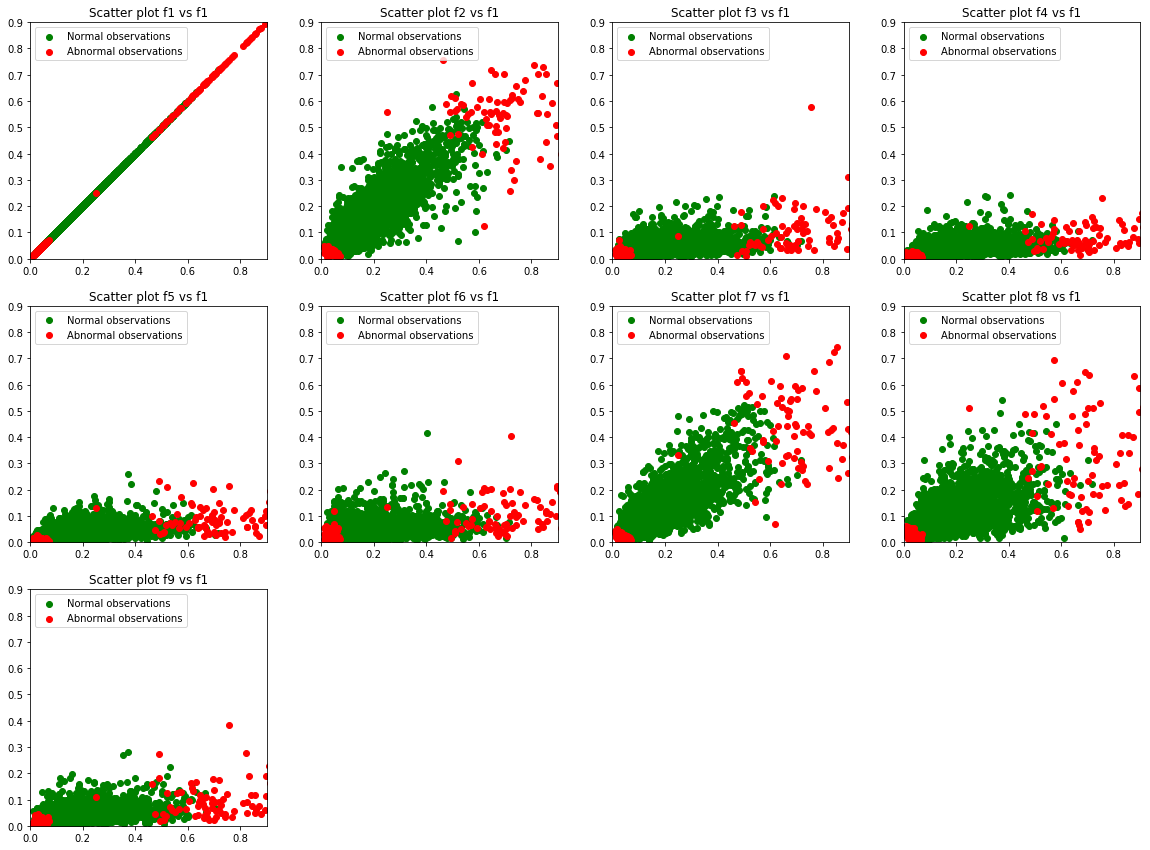

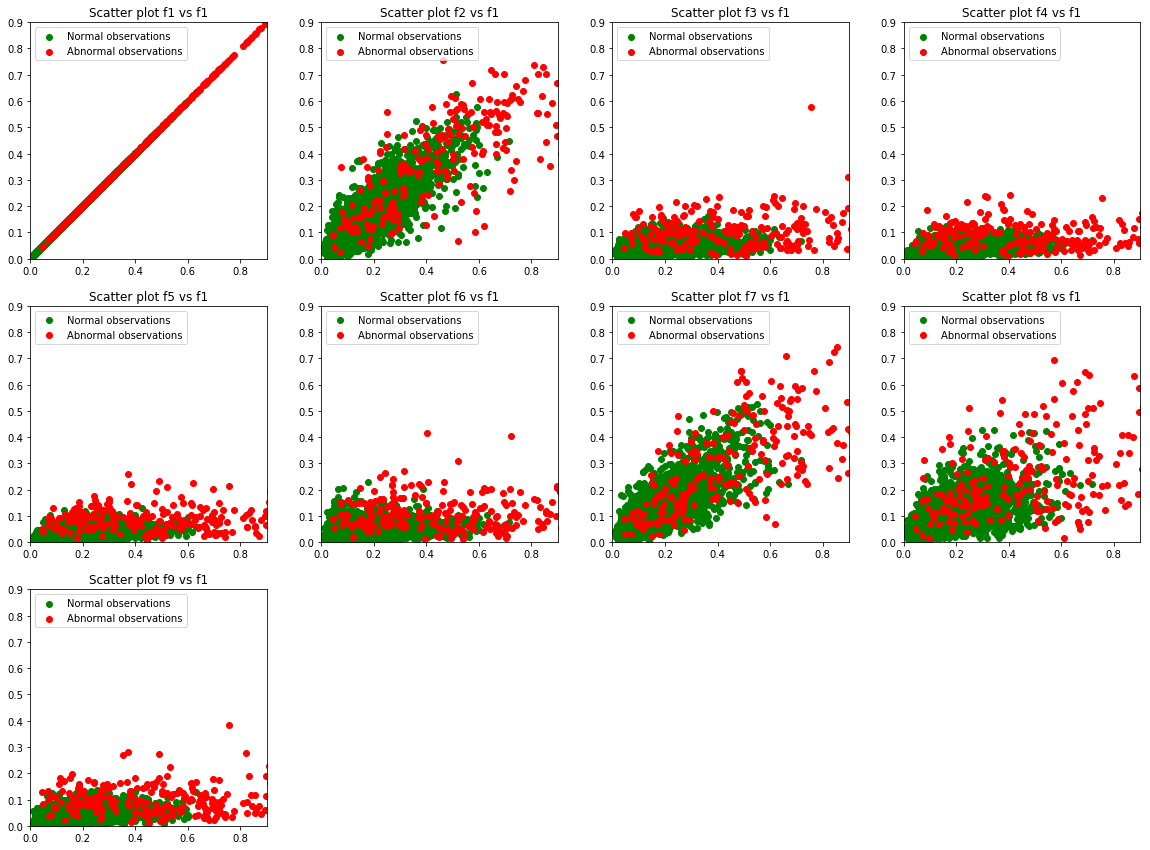

In [29]:
plotonevsall(y_pred_test_OSVM_all,'f1')
plotonevsall(y_pred_test_IF_all,'f1')

In [30]:
#Function for plotting all variable against self to identify outliers, it takes model as input
#Input parameters - Name of Trained Model

def plotselfall(modelcol):

    fig = plt.figure(figsize=(20,20))
    
    ax1 = fig.add_subplot(4,4,1)
    ax1.imshow(plt.imread(plotprediction(modelcol, 'f1', 'f1')))

    ax2 = fig.add_subplot(4,4,2)
    ax2.imshow(plt.imread(plotprediction(modelcol, 'f2', 'f2')))

    ax3 = fig.add_subplot(4,4,3)
    ax3.imshow(plt.imread(plotprediction(modelcol, 'f3', 'f3')))

    ax4 = fig.add_subplot(4,4,4)
    ax4.imshow(plt.imread(plotprediction(modelcol, 'f4', 'f4')))

    ax5 = fig.add_subplot(4,4,5)
    ax5.imshow(plt.imread(plotprediction(modelcol, 'f5', 'f5')))

    ax6 = fig.add_subplot(4,4,6)
    ax6.imshow(plt.imread(plotprediction(modelcol, 'f6', 'f6')))

    ax7 = fig.add_subplot(4,4,7)
    ax7.imshow(plt.imread(plotprediction(modelcol, 'f7', 'f7')))

    ax8 = fig.add_subplot(4,4,8)
    ax8.imshow(plt.imread(plotprediction(modelcol, 'f8', 'f8')))

    ax9 = fig.add_subplot(4,4,9)
    ax9.imshow(plt.imread(plotprediction(modelcol, 'f9', 'f9')))
    
    plt.show()


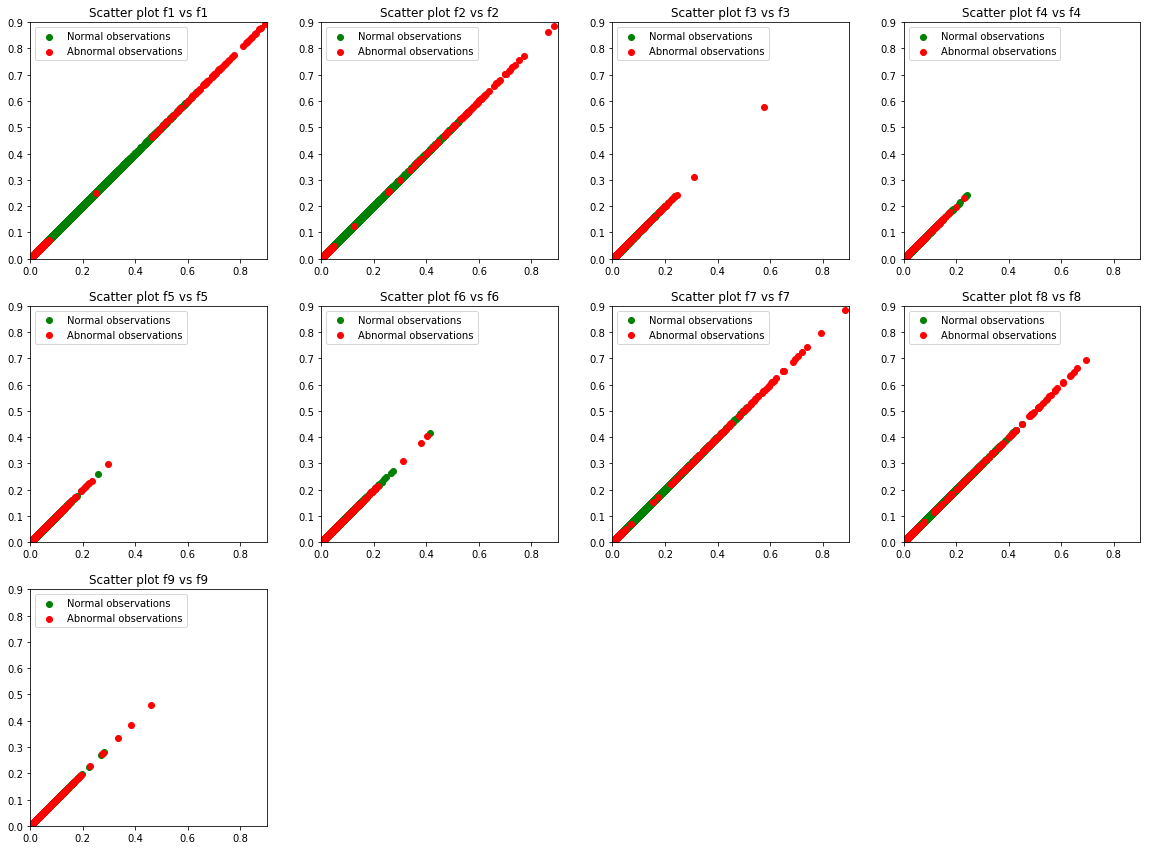

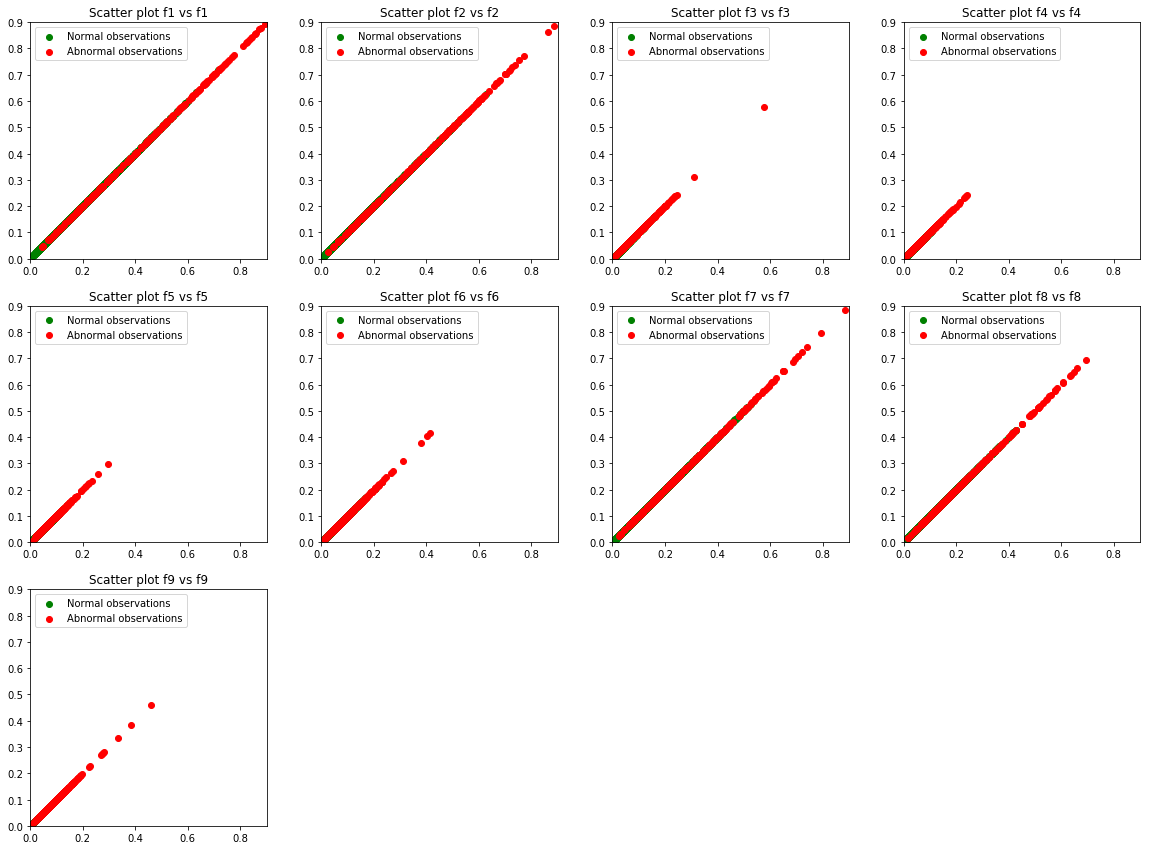

In [31]:
plotselfall(y_pred_test_OSVM_all) # One class SVM Model
plotselfall(y_pred_test_IF_all) # Isolation Forest Model


#plotselfall(fcol9)

In [32]:
#code for considering combination of individual variable model and one class SVM 
fcolarray = np.vstack((fcol1, fcol2, fcol3, fcol4, fcol5, fcol6, fcol7, fcol8, fcol9,y_pred_test_OSVM_all))

col = np.zeros( (1,int(fcolarray[1,:].shape[0]))) 
fcolfinal = np.vstack((fcolarray,col))
print(fcolfinal[10,:])


for i in range(len(fcolfinal[0,:])):
    if (fcolfinal[0,i]==-1 or fcolfinal[1,i]==-1 or fcolfinal[2,i]==-1 or fcolfinal[3,i]==-1 or fcolfinal[4,i]==-1 or fcolfinal[5,i]==-1 or fcolfinal[6,i]==-1 or fcolfinal[7,i]==-1 or fcolfinal[8,i]==-1) and (fcolfinal[9,i]==-1) :
        fcolfinal[10,i] = -1
    else :
        fcolfinal[10,i] = 1
        
    #print fcolfinal[10,i]
print(fcolfinal[10,:])

"""
for i in range(len(fcolfinal[0,:])):
    fcolfinal[10,i] = np.where( (fcolfinal[0,i]==-1 or fcolfinal[1,i]==-1 or fcolfinal[2,i]==-1 or fcolfinal[3,i]==-1 or fcolfinal[4,i]==-1 or fcolfinal[5,i]==-1 or fcolfinal[6,i]==-1 or fcolfinal[7,i]==-1 or fcolfinal[8,i]==-1) and (fcolfinal[9,i]==-1) ,'-1','1')
    print fcolfinal[10,i]
print(fcolfinal[10,:])
"""

[ 0.  0.  0. ...,  0.  0.  0.]
[ 1.  1.  1. ...,  1.  1.  1.]


"\nfor i in range(len(fcolfinal[0,:])):\n    fcolfinal[10,i] = np.where( (fcolfinal[0,i]==-1 or fcolfinal[1,i]==-1 or fcolfinal[2,i]==-1 or fcolfinal[3,i]==-1 or fcolfinal[4,i]==-1 or fcolfinal[5,i]==-1 or fcolfinal[6,i]==-1 or fcolfinal[7,i]==-1 or fcolfinal[8,i]==-1) and (fcolfinal[9,i]==-1) ,'-1','1')\n    print fcolfinal[10,i]\nprint(fcolfinal[10,:])\n"

In [33]:
#join all coloumns fcol1-9

#fnewcol = np.zeros( (np.count_nonzero(fcol1))) 

#fnewcol = np.where( np.logical_and( np.logical_or(fcol1==-1,fcol2==-1,fcol3==-1,fcol4==-1,fcol5==-1,fcol6==-1,fcol7==-1,fcol8==-1,fcol9==-1), y_pred_test_OSVM_all=='-1'),'-1','1')

#fnewcol = np.where( np.any(fcol1<0,fcol2<0),'-1','1')

#fnewcol.shape

#plotselfall(fcol2)
print(np.count_nonzero( np.where(fcolfinal[10,:]==-1) ) )

188


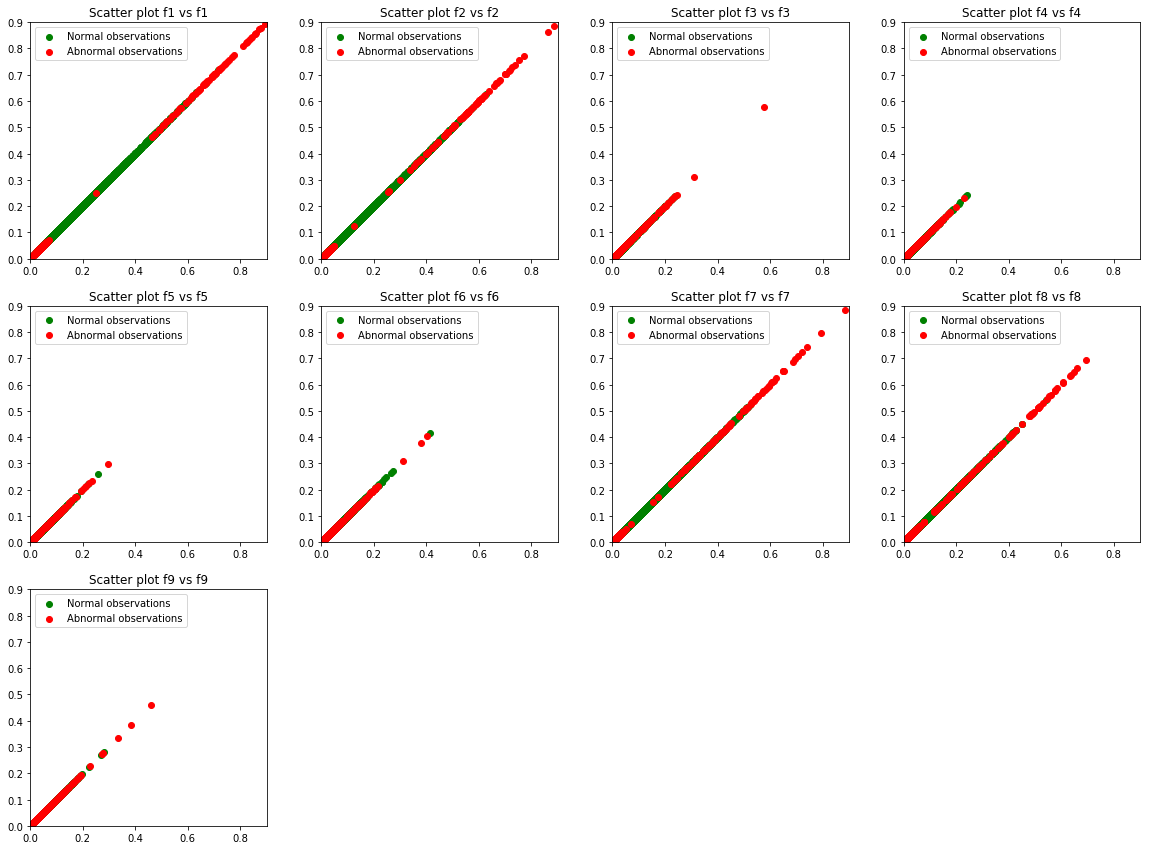

In [34]:
plotselfall(fcolfinal[10,:]) # One class SVM Model + Individual Model

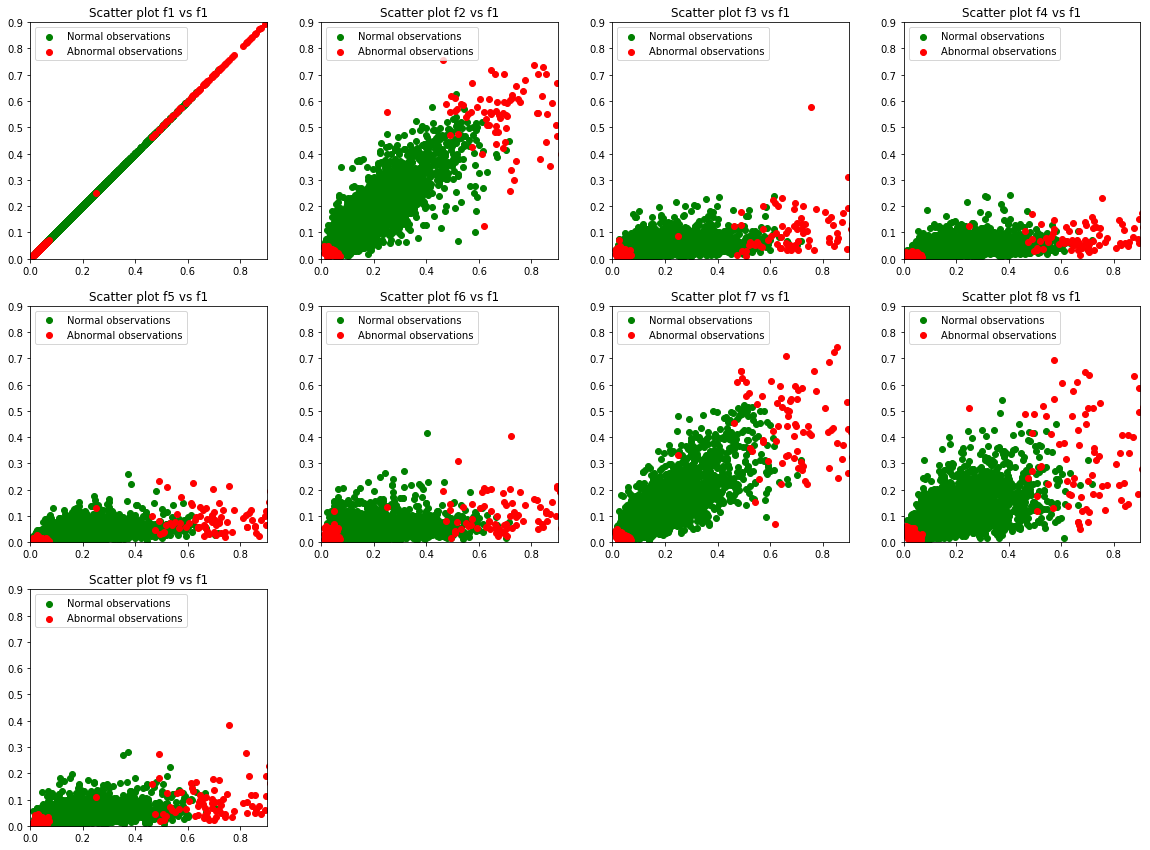

In [35]:
plotonevsall(fcolfinal[10,:],'f1')

In [36]:
#create log instances of variables
logoddarr = np.log(oddataarr)

#Divide the data into training and test set
msk = np.random.rand(len(logoddarr)) < 0.8

trainlog = logoddarr[msk]

testlog = logoddarr[~msk]
print(list(testlog))

['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9']


In [37]:
#fit the model One class svm for log variables
clf = OneClassSVM(kernel='rbf', degree=3, gamma='auto', coef0=0.0, tol=0.001, nu=0.02, random_state=rng)
clf.fit(trainlog)
#y_pred_train = clf.predict(train)
y_pred_test_log_OSVM_all = clf.predict(testlog)

In [38]:
print(len(y_pred_test_log_OSVM_all))
print(len(y_pred_test_log_OSVM_all[y_pred_test_log_OSVM_all==1]))
print(len(y_pred_test_log_OSVM_all[y_pred_test_log_OSVM_all==-1]))

4175
4088
87


In [39]:
plotselfall(y_pred_test_log_OSVM_all) # One class SVM Model with Logdata

C:\Users\PD186042\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


IndexingError: Unalignable boolean Series key provided

In [ ]:
#Plotting and histogram of - normal and log variables

fig = plt.figure(figsize=(10,30))
    
ax1 = fig.add_subplot(9,2,1)
ax1.hist(oddataarr.f1, bins='auto')
#plt.title("Histogram with 'auto' bins")

ax1 = fig.add_subplot(9,2,2)
ax1.hist(logoddarr.f1, bins='auto')

ax1 = fig.add_subplot(9,2,3)
ax1.hist(oddataarr.f2, bins='auto')

ax1 = fig.add_subplot(9,2,4)
ax1.hist(logoddarr.f2, bins='auto')

ax1 = fig.add_subplot(9,2,5)
ax1.hist(oddataarr.f3, bins='auto')

ax1 = fig.add_subplot(9,2,6)
ax1.hist(logoddarr.f3, bins='auto')

ax1 = fig.add_subplot(9,2,7)
ax1.hist(oddataarr.f4, bins='auto')

ax1 = fig.add_subplot(9,2,8)
ax1.hist(logoddarr.f4, bins='auto')

ax1 = fig.add_subplot(9,2,9)
ax1.hist(oddataarr.f5, bins='auto')

ax1 = fig.add_subplot(9,2,10)
ax1.hist(logoddarr.f5, bins='auto')

ax1 = fig.add_subplot(9,2,11)
ax1.hist(oddataarr.f6, bins='auto')

ax1 = fig.add_subplot(9,2,12)
ax1.hist(logoddarr.f6, bins='auto')

ax1 = fig.add_subplot(9,2,13)
ax1.hist(oddataarr.f7, bins='auto')

ax1 = fig.add_subplot(9,2,14)
ax1.hist(logoddarr.f7, bins='auto')

ax1 = fig.add_subplot(9,2,15)
ax1.hist(oddataarr.f8, bins='auto')

ax1 = fig.add_subplot(9,2,16)
ax1.hist(logoddarr.f8, bins='auto')

ax1 = fig.add_subplot(9,2,17)
ax1.hist(oddataarr.f9, bins='auto')

ax1 = fig.add_subplot(9,2,18)
ax1.hist(logoddarr.f9, bins='auto')

plt.show()

In [ ]:

#Having a look at box plot for - normal and log variables

fig = plt.figure(figsize=(5,15))
    
ax1 = fig.add_subplot(2,1,1)
ax1.boxplot(oddataarr.f1)

ax2 = fig.add_subplot(2,1,2)
ax2.boxplot(logoddarr.f1)

plt.show()


In [ ]:
#Model using Box plot whiskers

_, bp = pd.DataFrame.boxplot(oddataarr, return_type='both')

outliers = [flier.get_ydata() for flier in bp["fliers"]]
boxes = [box.get_ydata() for box in bp["boxes"]]
medians = [median.get_ydata() for median in bp["medians"]]
whiskers = [whiskers.get_ydata() for whiskers in bp["whiskers"]]



#print(len(whiskers)/2)

oddataarrval = test.values
foutlier = np.zeros(oddataarrval.shape)

def runoutlier(col):
    for i in range(len(whiskers)):
        for j in range(len(oddataarrval[:,0])):
            if ( oddataarrval[j,col] <= whiskers[i][1] or oddataarrval[j,col] >= whiskers[i+1][1] ) :
                foutlier[j,col] = -1
            else :
                foutlier[j,col] = 1

        i=i+2
        if i==18:
            break
runoutlier(0)
runoutlier(1)
runoutlier(2)
runoutlier(3)
runoutlier(4)
runoutlier(5)
runoutlier(6)
runoutlier(7)
runoutlier(8)
print(oddataarrval.shape)
print(whiskers[16][1])
print(foutlier[:,1])

In [ ]:
#outlier prediction on test data by using outlier whisker information of Box plot 
plotselfall(foutlier[:,1])

"""
print(type(y_pred_test_OSVM_all))
print(y_pred_test_OSVM_all.shape)
print(type(foutlier[:,0]))
print(foutlier[:,0].shape)
"""

In [ ]:
import h2o

In [ ]:
h2o.init()

In [ ]:
# Import ECG train and test data into the H2O cluster 
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator 


In [ ]:

train_ecg = h2o.import_file("http://h2o-public-test-data.s3.amazonaws.com/smalldata/anomaly/ecg_discord_train.csv")
test_ecg = h2o.import_file("http://h2o-public-test-data.s3.amazonaws.com/smalldata/anomaly/ecg_discord_test.csv")

In [52]:
numpyMatrix = train.as_matrix()

print(numpyMatrix.shape)

trainecg = h2o.H2OFrame(numpyMatrix)
trainecg.shape

(16959L, 9L)
Parse progress: |█████████████████████████████████████████████████████████| 100%


(16959, 9)

In [54]:
# Train deep autoencoder learning model on "normal" 
# training data, y ignored
anomaly_model = H2OAutoEncoderEstimator( 
        activation="Tanh", 
        hidden=[50,50,50], 
        sparse=True,
        l1=1e-4, 
        epochs=100)
anomaly_model.train(
    x=trainecg.names,  
        training_frame=trainecg)                


deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [55]:
numpyMatrix = test.as_matrix()

print(numpyMatrix.shape)

testecg = h2o.H2OFrame(numpyMatrix)
testecg.shape

(4235L, 9L)
Parse progress: |█████████████████████████████████████████████████████████| 100%


(4235, 9)

In [57]:
# Compute reconstruction error with the Anomaly 
# detection app (MSE between output and input layers)
recon_error = anomaly_model.anomaly(testecg)
recon_error

Reconstruction.MSE
0.00043669
0.000172915
0.000139332
0.000206598
0.000281552
0.000440991
0.000313265
0.000307625
0.000454393
0.000283749


In [58]:
# Note: Testing = Reconstructing the test dataset
test_recon = anomaly_model.predict(testecg) 
test_recon

deeplearning prediction progress: |███████████████████████████████████████| 100%


reconstr_C1,reconstr_C2,reconstr_C3,reconstr_C4,reconstr_C5,reconstr_C6,reconstr_C7,reconstr_C8,reconstr_C9
0.15323,0.119101,0.0425224,0.0338979,0.020289,0.0540934,0.100739,0.087233,0.0370633
0.200475,0.165663,0.0488435,0.0400348,0.0278497,0.0607275,0.141702,0.096839,0.0435174
0.182725,0.149272,0.048188,0.0387702,0.0247324,0.0594791,0.121336,0.13126,0.0425136
0.177651,0.143075,0.0468985,0.0380084,0.0252081,0.058781,0.120869,0.0994102,0.0414293
0.160344,0.126059,0.0449755,0.0360688,0.022691,0.0567557,0.105302,0.0999815,0.0394195
0.155051,0.120427,0.0439126,0.0352292,0.0221803,0.0558629,0.102248,0.0869875,0.0384299
0.161597,0.126035,0.048665,0.0395338,0.0275388,0.0614785,0.105686,0.102256,0.0429984
0.186944,0.151388,0.0489164,0.0401314,0.0285629,0.0614098,0.130311,0.0894385,0.0435288
0.157514,0.123753,0.0436909,0.0347985,0.0208058,0.0550977,0.102597,0.102338,0.0381336
0.223545,0.187089,0.0596684,0.0498044,0.0396045,0.0731312,0.156249,0.137265,0.0539523
